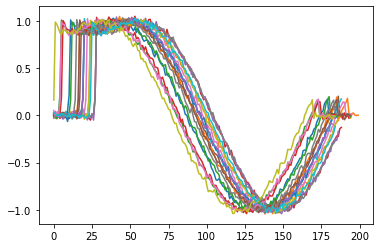

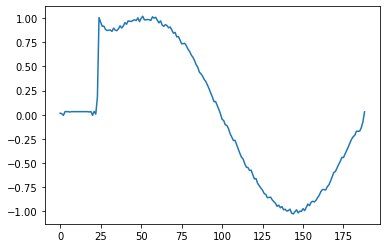

In [1]:
#https://github.com/fpetitjean/DBA/blob/master/DBA.py
'''
/*******************************************************************************
 * Copyright (C) 2018 Francois Petitjean
 *
 * This program is free software: you can redistribute it and/or modify
 * it under the terms of the GNU General Public License as published by
 * the Free Software Foundation, version 3 of the License.
 *
 * This program is distributed in the hope that it will be useful,
 * but WITHOUT ANY WARRANTY; without even the implied warranty of
 * MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 * GNU General Public License for more details.
 *
 * You should have received a copy of the GNU General Public License
 * along with this program.  If not, see <http://www.gnu.org/licenses/>.
 ******************************************************************************/
'''
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import math

__author__ ="Francois Petitjean"

def performDBA(series, n_iterations=10):
    n_series = len(series)
    max_length = reduce(max, map(len, series))

    cost_mat = np.zeros((max_length, max_length))
    delta_mat = np.zeros((max_length, max_length))
    path_mat = np.zeros((max_length, max_length), dtype=np.int8)

    medoid_ind = approximate_medoid_index(series,cost_mat,delta_mat)
    center = series[medoid_ind]

    for i in range(0,n_iterations):
        center = DBA_update(center, series, cost_mat, path_mat, delta_mat)

    return center

def approximate_medoid_index(series,cost_mat,delta_mat):
    if len(series)<=50:
        indices = range(0,len(series))
    else:
        indices = np.random.choice(range(0,len(series)),50,replace=False)

    medoid_ind = -1
    best_ss = 1e20
    for index_candidate in indices:
        candidate = series[index_candidate]
        ss = sum_of_squares(candidate,series,cost_mat,delta_mat)
        if(medoid_ind==-1 or ss<best_ss):
            best_ss = ss
            medoid_ind = index_candidate
    return medoid_ind

def sum_of_squares(s,series,cost_mat,delta_mat):
    return sum(map(lambda t:squared_DTW(s,t,cost_mat,delta_mat),series))

def DTW(s,t,cost_mat,delta_mat):
    return np.sqrt(squared_DTW(s,t,cost_mat,delta_mat))

def squared_DTW(s,t,cost_mat,delta_mat):
    s_len = len(s)
    t_len = len(t)
    length = len(s)
    fill_delta_mat_dtw(s, t, delta_mat)
    cost_mat[0, 0] = delta_mat[0, 0]
    for i in range(1, s_len):
        cost_mat[i, 0] = cost_mat[i-1, 0]+delta_mat[i, 0]

    for j in range(1, t_len):
        cost_mat[0, j] = cost_mat[0, j-1]+delta_mat[0, j]

    for i in range(1, s_len):
        for j in range(1, t_len):
            diag,left,top =cost_mat[i-1, j-1], cost_mat[i, j-1], cost_mat[i-1, j]
            if(diag <=left):
                if(diag<=top):
                    res = diag
                else:
                    res = top
            else:
                if(left<=top):
                    res = left
                else:
                    res = top
            cost_mat[i, j] = res+delta_mat[i, j]
    return cost_mat[s_len-1,t_len-1]

def fill_delta_mat_dtw(center, s, delta_mat):
    slim = delta_mat[:len(center),:len(s)]
    np.subtract.outer(center, s,out=slim)
    np.square(slim, out=slim)

def DBA_update(center, series, cost_mat, path_mat, delta_mat):
    options_argmin = [(-1, -1), (0, -1), (-1, 0)]
    updated_center = np.zeros(center.shape)
    n_elements = np.array(np.zeros(center.shape), dtype=int)
    center_length = len(center)
    for s in series:
        s_len = len(s)
        fill_delta_mat_dtw(center, s, delta_mat)
        cost_mat[0, 0] = delta_mat[0, 0]
        path_mat[0, 0] = -1

        for i in range(1, center_length):
            cost_mat[i, 0] = cost_mat[i-1, 0]+delta_mat[i, 0]
            path_mat[i, 0] = 2

        for j in range(1, s_len):
            cost_mat[0, j] = cost_mat[0, j-1]+delta_mat[0, j]
            path_mat[0, j] = 1

        for i in range(1, center_length):
            for j in range(1, s_len):
                diag,left,top =cost_mat[i-1, j-1], cost_mat[i, j-1], cost_mat[i-1, j]
                if(diag <=left):
                    if(diag<=top):
                        res = diag
                        path_mat[i,j] = 0
                    else:
                        res = top
                        path_mat[i,j] = 2
                else:
                    if(left<=top):
                        res = left
                        path_mat[i,j] = 1
                    else:
                        res = top
                        path_mat[i,j] = 2

                cost_mat[i, j] = res+delta_mat[i, j]

        i = center_length-1
        j = s_len-1

        while(path_mat[i, j] != -1):
            updated_center[i] += s[j]
            n_elements[i] += 1
            move = options_argmin[path_mat[i, j]]
            i += move[0]
            j += move[1]
        assert(i == 0 and j == 0)
        updated_center[i] += s[j]
        n_elements[i] += 1

    return np.divide(updated_center, n_elements)

def main():
    #generating synthetic data
    n_series = 20
    length = 200
    

    series = list()
    padding_length=30
    indices = range(0, length-padding_length)
    main_profile_gen = np.array([np.sin(2*np.pi*(j+80/(1+math.sqrt(j)))/len(indices)) for j in indices])
    randomizer = lambda j:np.random.normal(j,0.02)
    randomizer_fun = np.vectorize(randomizer)
    for i in range(0,n_series):
        n_pad_left = np.random.randint(0,padding_length)
        #adding zero at the start or at the end to shif the profile
        series_i = np.pad(main_profile_gen,(n_pad_left,padding_length-n_pad_left),mode='constant',constant_values=0)
        #chop some of the end to prove it can work with multiple lengths
        l = np.random.randint(length-20,length+1)
        series_i = series_i[:l]
        #randomize a bit
        series_i = randomizer_fun(series_i)

        series.append(series_i)
    series = np.array(series, dtype=object)

    #plotting the synthetic data
    for s in series:
        plt.plot(range(0,len(s)), s)
    plt.draw()

    #calculating average series with DBA
    average_series = performDBA(series)

    #plotting the average series
    plt.figure()
    plt.plot(range(0,len(average_series)), average_series)
    plt.show()

if __name__== "__main__":
    main()